# Pytorch example

This file shows a minimal pytorch example running on adult data, and demonstrating head-merging.

In general, we strongly recommend that you *do not* use neural networks on tabular data. Boosting is typically higher performing and much faster to run.

However, this is a toy example, and unlike computer vision examples, it should train and run in a matter of minutes. The techniques shown will directly apply to computer vision and NLP without modification.

In [1]:
# Load libraries

import oxonfair
from oxonfair import group_metrics as gm

import numpy as np
import torch
import torch.nn.functional as F
from torch import nn, optim


In [2]:
#Load adult dataset, using sex as the default groups and discard sex from the raw data
train, val, test = oxonfair.dataset_loader.adult(discard_groups=True)

In [3]:
#Normalise data
std = train['data'].std()
train['data'] = train['data'] / std
val['data'] = val['data'] / std
test['data'] = test['data'] / std

In [4]:
#define a basic nn with 2 hidden-layers. 1 of width 100, and the second width 50.
network = nn.Sequential(nn.Linear(train['data'].shape[1],100),
                        nn.SELU(),
                        nn.Linear(100,50),
                        nn.SELU(),
                        nn.Linear(50,2))

In [5]:
# Define a custom loss that trains the two-heads as required.
def loss(x, y, g):
    output = network(x)
    loss0 = F.binary_cross_entropy_with_logits(output[:,0], y)
    loss1 = F.mse_loss(output[:,1], g)
    return loss0+loss1


In [6]:
# Copy variables to tensors
target = torch.tensor(train['target']).float()
data = torch.tensor(np.asarray(train['data'])).float()
groups = torch.tensor(train['groups']==' Male').float()

optimizer = optim.Adam(network.parameters(), lr=1e-4)
from numpy import random

In [7]:
# Train the network
batch_size = 50

for epoch in range(100):
    #shuffle data
    perm = random.permutation(target.shape[0])
    target = target[perm]
    data = data[perm]
    groups = groups[perm]
    if epoch%10==0:
        print ('epoch is %d'%epoch)
    for step in range(target.shape[0]//batch_size): # This discards the final incomplete batch
        optimizer.zero_grad()
        l = loss(data[step*batch_size:(1+step)*batch_size],
                 target[step*batch_size:(1+step)*batch_size],
                 groups[step*batch_size:(1+step)*batch_size])
        l.backward()
        optimizer.step()

epoch is 0
epoch is 10
epoch is 20
epoch is 30
epoch is 40
epoch is 50
epoch is 60
epoch is 70
epoch is 80
epoch is 90


In [8]:
#convert test['data'] to tensor via numpy and then move the output back to numpy
test_output=np.asarray(network(torch.tensor(np.asarray(test['data'])).float()).detach())


To see if training works we visualize the outputs of the second head (corresponding to gender)

Ideally, this should be a two peaked distribution centered on 0 and 1, with more values at 1 -- corresponding to the male label.

Instead, we find we have 1 peak centered on 1, a broader central peak corresponding to 'don't know' centered around 0.5 and a third smaller peak around 0.2 and 0.

This is fine. The broad central peak reflects the ambiguity of the task, and otherwise we do have something of a split into male and female.

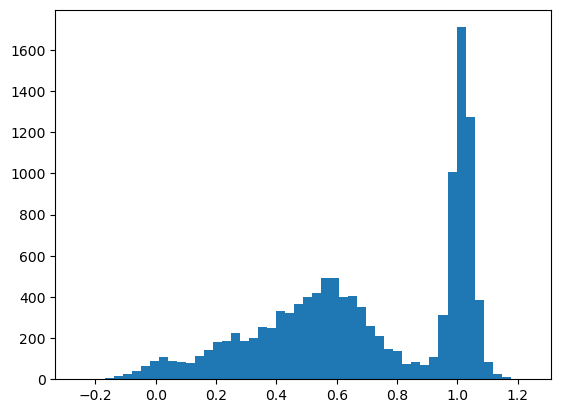

In [9]:
#Plot the outputs of the second head
from matplotlib import pyplot as plt
_=plt.hist(test_output[:,1],bins=50)

In [10]:
#Let's train a fair classifier using the two heads 
#convert val['data'] to tensor via numpy and then move the output back to numpy
val_output = np.asarray(network(torch.tensor(np.asarray(val['data'])).float()).detach())


In [11]:
fpred = oxonfair.DeepFairPredictor(val['target'],
                                   val_output,
                                   groups=val['groups'])
# Enforce fairness on validation data -- i.e. demographic/statistical parity should be within 2 %
fpred.fit(gm.accuracy, gm.demographic_parity, 0.02,grid_width=75)
# Varying the grid with can improve accuracy at the cost of a longer search time.

In [12]:
# Check performance drop
fpred.evaluate()

,original,updated
Accuracy,0.852170,0.837183
Balanced Accuracy,0.733593,0.704507
F1 score,0.621037,0.569511
MCC,0.557051,0.504594
Precision,0.803368,0.775354
Recall,0.506160,0.450034
ROC AUC,0.907850,0.894249


In [13]:
# and fairness
fpred.evaluate_fairness()

,original,updated
Statistical Parity,0.147951,0.015993
Predictive Parity,0.055324,0.253787
Equal Opportunity,0.120342,0.297030
Average Group Difference in False Negative Rate,0.120342,0.297030
Equalized Odds,0.084993,0.162143
Conditional Use Accuracy,0.083531,0.213775
Average Group Difference in Accuracy,0.112128,0.117919
Treatment Equality,0.163322,1.458469


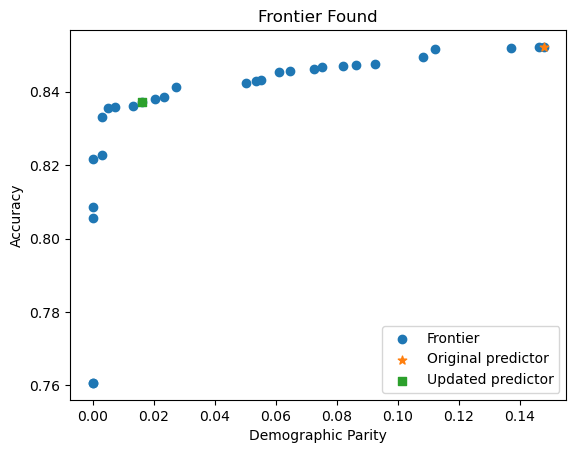

In [14]:
#Visualise the possible trade-offs
fpred.plot_frontier()

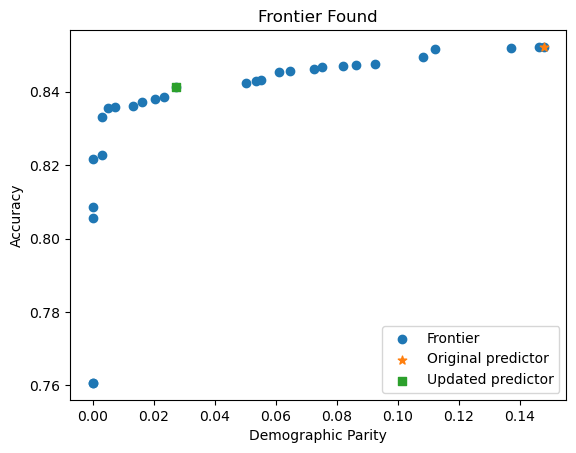

In [15]:
#To quickly select another point from the frontier, you can call it with recompute=False
fpred.fit(gm.accuracy, gm.demographic_parity, 0.05, recompute=False)
fpred.plot_frontier()


In [16]:
# to evaluate how it's working on the test set, we'll create a new dataset holder
test_network = oxonfair.DeepDataDict(test['target'], test_output, test['groups'])

In [17]:
#And evaluate
fpred.evaluate(test_network)

,original,updated
Accuracy,0.851937,0.837769
Balanced Accuracy,0.730736,0.717201
F1 score,0.616949,0.589089
MCC,0.555631,0.511426
Precision,0.809789,0.747762
Recall,0.498289,0.485969
ROC AUC,0.905296,0.888789


In [18]:
fpred.evaluate_fairness()

,original,updated
Statistical Parity,0.147951,0.027185
Predictive Parity,0.055324,0.257181
Equal Opportunity,0.120342,0.273454
Average Group Difference in False Negative Rate,0.120342,0.273454
Equalized Odds,0.084993,0.149802
Conditional Use Accuracy,0.083531,0.210693
Average Group Difference in Accuracy,0.112128,0.105141
Treatment Equality,0.163322,1.792626


In [19]:
# Now let's merge the heads
# We examine the coefficients first.
fpred.extract_coefficients()

(-2.084, 1.782)

The block below shows the merging step for two groups. 

When only two groups exist, we are using a binary encoding of groups and trying to predict either 0 or 1.
The parameters we learn correspond to a scalar `a`, and bias `b`, and the predictions made by the merging:

    classification_head + a * group_head +b

should be fair and performant.

When more than two groups exist, you should have trained the second head to output a one-hot encoding of the groups and the merging:

    classification_head + a.dot(group_head)

should be fair and performant.

In [20]:
# We copy the network and create a fair version
import copy
fair_network= copy.deepcopy(network)
# We replace the final linear layer with a 1 dimensional head.
fair_network[4]=nn.Linear(50,1)
#Now we merge the weights 
fair_network[4].weight.data[:] = (network[4].weight[0] + fpred.extract_coefficients()[0]*network[4].weight[1]).data
# and the biases
fair_network[4].bias.data[:] = (network[4].bias[0] + fpred.extract_coefficients()[0]*network[4].bias[1]).data
# and add the extra bias term
fair_network[4].bias.data += fpred.extract_coefficients()[1]


In [21]:
# Now let's check the fair classifier on the test set.
test_fair_output=np.asarray(fair_network(torch.tensor(np.asarray(test['data'])).float()).detach())

In [22]:
# As expected the accuracy is identical to what was reported before.

oxonfair.performance.evaluate(test['target'],test_fair_output.reshape(-1))

,0
Accuracy,0.837851
Balanced Accuracy,0.717372
F1 score,0.589382
MCC,0.511719
Precision,0.747895
Recall,0.486311
ROC AUC,0.888800


In [23]:
# And so is the fairness
oxonfair.performance.evaluate_fairness(test['target'],test_fair_output.reshape(-1),test['groups'])

,0
Statistical Parity,0.016946
Predictive Parity,0.268903
Equal Opportunity,0.301356
Average Group Difference in False Negative Rate,0.301356
Equalized Odds,0.166554
Conditional Use Accuracy,0.219282
Average Group Difference in Accuracy,0.105828
Treatment Equality,2.084835


In [24]:
# Finally, let's compare to a range of other oxonfair based classifiers.
# These don't support head merging
# 1. The base method that just picks the most likely group label instead of keeping track of the value returned 
fpred_standard = oxonfair.DeepFairPredictor(val['target'],
                                              val_output,
                                              groups=val['groups'], use_fast=True)
# 2. A classifier that enforces fairness by using the actual group labels instead of inferred.
fpred_true_groups = oxonfair.DeepFairPredictor(val['target'],
                                              val_output,
                                              groups=val['groups'], use_fast=True,use_actual_groups=True)


# 3. Single threshold. This adjusts the global bias only, without considering group membership.
# It works surprisingly well for criteria like recall.min, but is less useful for fairness
fpred_thresh  = oxonfair.DeepFairPredictor(val['target'],
                                              val_output,
                                              groups=val['groups'], use_actual_groups='single_threshold')


In [25]:
fpred_standard.fit(gm.accuracy,gm.demographic_parity,0.05)
fpred_true_groups.fit(gm.accuracy,gm.demographic_parity,0.05)
fpred_thresh.fit(gm.accuracy,gm.demographic_parity,0.05)

Fewer groups used (1) in infered groups than in the true groups (2)


(0.75, 0.8835872235872236)

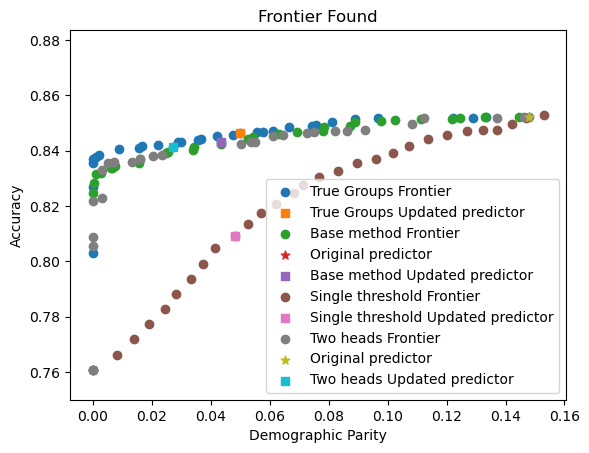

In [26]:
# Plot of curves on validation data
# This shows that the first three approaches are basically interchangable
fpred_true_groups.plot_frontier(prefix='True Groups ', new_plot=False, show_original=False)
fpred_standard.plot_frontier(prefix='Base method ', new_plot=False)
fpred_thresh.plot_frontier(prefix='Single threshold ', new_plot=False, show_original=False)
fpred.plot_frontier(prefix='Two heads ', new_plot=False)
plt.ylim(bottom=0.75)